In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub

!pip install tf-models-official &> /dev/null
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

!pip install transformers &> /dev/null
from transformers import BertTokenizer

from sklearn.model_selection import train_test_split

In [2]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')
  
from google.colab import files
uploaded = files.upload()


Found GPU at: /device:GPU:0


Saving FA18_sentences.xlsx to FA18_sentences.xlsx


In [3]:
df_fall_18_messages = pd.read_excel('FA18_sentences.xlsx', index_col=0)

# Get the lists of sentences and their labels.
sentences = df_fall_18_messages['Sentence'].values
labels = df_fall_18_messages['Recipient Gender'].values

print(df_fall_18_messages.shape)
df_fall_18_messages.head()

(6354, 2)


,Sentence,Recipient Gender
0,Hey @Katie Poteet I know you said we should em...,1
1,I’m planning to do the Baltimore Community Too...,1
2,@Mary Cassell I would email Dr. K anyway with ...,1
3,"If not, it’s still good for her to know what y...",1
4,"Ok, thanks a lot.",1


In [4]:
trainX, testX, trainY, testY = train_test_split(sentences, labels, shuffle=True, test_size=0.25)
print('trainX:',trainX.shape)
print('trainY:',trainY.shape)
print('testX:',testX.shape)
print('testY:',testY.shape)

trainX: (4765,)
trainY: (4765,)
testX: (1589,)
testY: (1589,)


In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
def convert_example_to_feature(sentence):
  
  # combine step for tokenization, WordPiece vector mapping, adding special tokens as well as truncating reviews longer than the max length
  
  return tokenizer.encode_plus(sentence, 
                add_special_tokens = True, # add [CLS], [SEP]
                max_length = 105, # max length of the text that can go to BERT
                pad_to_max_length = True, # add [PAD] tokens
                return_attention_mask = True, # add attention mask to not focus on pad tokens
              )

In [6]:
def encode_examples(sentences, labels, limit=-1):

  # prepare list, so that we can build up final TensorFlow dataset from slices.
  input_ids_list = []
  token_type_ids_list = []
  attention_mask_list = []
  label_list = []
    
  for i in range(0,len(sentences)):

    bert_input = convert_example_to_feature(sentences[i])
  
    input_ids_list.append(bert_input['input_ids'])
    token_type_ids_list.append(bert_input['token_type_ids'])
    attention_mask_list.append(bert_input['attention_mask'])
    label_list.append(labels[i])

  input_ids = np.array(input_ids_list)
  token_type_ids = np.array(token_type_ids_list)
  attention_mask = np.array(attention_mask_list)
  labels = np.array(label_list)

  return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_mask,
      "labels": labels
  }


In [7]:
# train dataset
ds_train_encoded = encode_examples(trainX, trainY)

# test dataset
ds_test_encoded = encode_examples(testX,testY)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [8]:
print('Training Shapes:')
for key, value in ds_train_encoded.items():
  print(key,': ', value.shape)
print()
print("Testing Shapes: ")
for key, value in ds_test_encoded.items():
  print(key,': ', value.shape)


Training Shapes:
input_ids :  (4765, 105)
token_type_ids :  (4765, 105)
attention_mask :  (4765, 105)
labels :  (4765,)

Testing Shapes: 
input_ids :  (1589, 105)
token_type_ids :  (1589, 105)
attention_mask :  (1589, 105)
labels :  (1589,)


In [9]:
for i in range(0, 1):
  print(tokenizer.convert_ids_to_tokens(ds_train_encoded['input_ids'][i]),'\n')
  for key,values in ds_train_encoded.items():
    print(key, '[',i,']: ',ds_train_encoded[key][i],'\n')
  print()

['[CLS]', '@', 'ellie', 'von', '##der', '##hor', '##st', '@', 'faith', 'davis', '@', 'josh', 'gal', '##ita', '@', 'logan', 'line', '##burg', '@', 'matthew', 'owens', '@', 'priscilla', '@', 'lin', '##nea', 'collins', '@', 'joe', 'smith', '@', 'true', 'grit', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]'] 

input_ids [ 0 ]:  [  101  1030 10707  3854  4063 16368  3367  1030  4752  4482  1030  6498
 

In [11]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    input_type_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])
    out = Dense(5, activation='softmax',name="out")(pooled_output)
    model = Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=out,name="BERT_model")    
    return model
    

In [12]:
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1'.
INFO:absl:Downloaded https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1, Total size: 1.26GB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1'.


In [13]:
model = build_model(bert_layer, max_len=105)
model.summary()

Model: "BERT_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 105)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 105)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 105)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]        

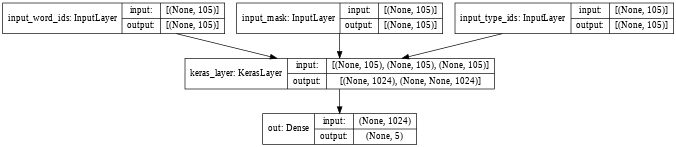

In [14]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

In [15]:
epochs = 10
# creates an optimizer with learning rate schedule
# recommended learning rate for Adam 5e-5, 3e-5, 2e-5
# optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
train_dict = {
    'input_word_ids': ds_train_encoded['input_ids'],
    'input_type_ids': ds_train_encoded['token_type_ids'],
    'input_mask': ds_train_encoded['attention_mask']
}

test_dict = {
    'input_word_ids': ds_test_encoded['input_ids'],
    'input_type_ids': ds_test_encoded['token_type_ids'],
    'input_mask': ds_test_encoded['attention_mask']
}
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

history = model.fit(
      train_dict, ds_train_encoded['labels'],
      validation_data=(test_dict, ds_test_encoded['labels']),
      batch_size=16,
      epochs=epochs)


Epoch 1/10
298/298 [==============================] - 382s 1s/step - loss: 1.1242 - accuracy: 0.4781 - val_loss: 0.9552 - val_accuracy: 0.5154
Epoch 2/10
298/298 [==============================] - 351s 1s/step - loss: 0.9105 - accuracy: 0.5686 - val_loss: 0.9593 - val_accuracy: 0.5343
Epoch 3/10
298/298 [==============================] - 351s 1s/step - loss: 0.7570 - accuracy: 0.6532 - val_loss: 1.0298 - val_accuracy: 0.5475
Epoch 4/10
298/298 [==============================] - 351s 1s/step - loss: 0.4686 - accuracy: 0.8056 - val_loss: 1.1097 - val_accuracy: 0.4783
Epoch 5/10
298/298 [==============================] - 350s 1s/step - loss: 0.4328 - accuracy: 0.8275 - val_loss: 1.3615 - val_accuracy: 0.5230
Epoch 6/10
298/298 [==============================] - 350s 1s/step - loss: 0.2005 - accuracy: 0.9208 - val_loss: 1.7157 - val_accuracy: 0.5356
Epoch 7/10
298/298 [==============================] - 350s 1s/step - loss: 0.1288 - accuracy: 0.9495 - val_loss: 1.6868 - val_accuracy: 0.5274

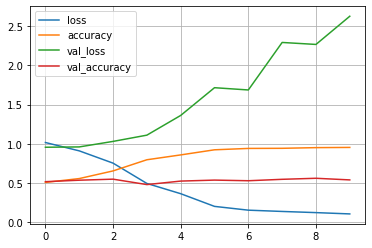

In [16]:
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot()
plt.grid(True)